In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"

In [5]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027E01C653D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027E02335100>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:

class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [11]:
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}

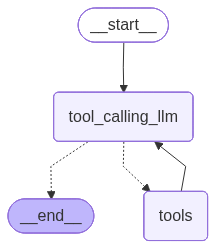

In [12]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
response=graph.invoke({"messages":"What is machine learning"})

In [14]:
response

{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='1b1c6bb7-fcac-4c70-8c8b-2a6ac9419337'),
  AIMessage(content='machine_learning={"name":"machine learning","description":"Machine learning is a field of study that focuses on the use of algorithms and statistical models to enable machines to perform a specific task without using explicit instructions, relying on patterns and data to learn and improve their performance over time.", "parameters":{},"required":{},"type":"object"}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 216, 'total_tokens': 284, 'completion_time': 0.126354776, 'prompt_time': 0.014589376, 'queue_time': 0.050811934, 'total_time': 0.140944152}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c0d5fbab-2330-486c-9153-ecea36254139-0', usage_metadata={'i

In [15]:
response=graph.invoke({"messages":"what is 5 plus 20"})

In [16]:
response

{'messages': [HumanMessage(content='what is 5 plus 20', additional_kwargs={}, response_metadata={}, id='72bd139d-af2e-4e1f-8a67-5d3d9b7a4922'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g9rkx7ccw', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 219, 'total_tokens': 237, 'completion_time': 0.034533865, 'prompt_time': 0.014072282, 'queue_time': 0.055362858, 'total_time': 0.048606147}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6934a402-0a2a-4b0e-a958-0bb339180193-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': 'g9rkx7ccw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 18, 'total_tokens': 237}),
  ToolMessage(content='25.0', name='add', id='d8f0d7bb-ace5-4b76-bb0b-4bddf8e949d9', tool_cal